# Importação de bibliotecas

In [1]:
from typing import Tuple, List
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

# Definição de constantes

In [2]:
np.random.seed(42)
K_NUMBER = 3
TARGET_COLUMN_NAME = "y"
TEST_SIZE = 0.2
HOLDOUT_INDEXES_NUMBER = 20
FIG_SIZE = (12, 8)

# Criando um dataset sintético

In [3]:
pattern_00 = np.array([[0, 0]] * 10)
pattern_01 = np.array([[0, 1]] * 10)
pattern_10 = np.array([[1, 0]] * 10)
pattern_11 = np.array([[1, 1]] * 10)

min_noise = -0.3
max_noise = 0.3
noise = np.random.uniform(min_noise, max_noise, size=(10, 2))

pattern_00_noisy = pattern_00 + noise
pattern_01_noisy = pattern_01 + noise
pattern_10_noisy = pattern_10 + noise
pattern_11_noisy = pattern_11 + noise

y_pattern_00 = np.array([[0]] * 10)
y_pattern_01 = np.array([[0]] * 10)
y_pattern_10 = np.array([[0]] * 10)
y_pattern_11 = np.array([[1]] * 10)

synthetic_df = pd.DataFrame(
    np.concatenate(
        [
            np.concatenate([pattern_00_noisy, y_pattern_00], axis=1),
            np.concatenate([pattern_01_noisy, y_pattern_01], axis=1),
            np.concatenate([pattern_10_noisy, y_pattern_10], axis=1),
            np.concatenate([pattern_11_noisy, y_pattern_11], axis=1),
        ]
    ),
    columns=["x1", "x2", "y"],
)

synthetic_df[TARGET_COLUMN_NAME] = synthetic_df[TARGET_COLUMN_NAME].astype(int)

# Verificando número de classes

In [4]:
synthetic_df[TARGET_COLUMN_NAME].unique()

array([0, 1])

# Redefinindo classes para valores numéricos não é necessário nesse dataset

# Funções diversas

In [5]:
def calculate_accuracy(y_true: np.array, y_pred: np.array) -> float:
    return np.sum(y_true == y_pred) / len(y_true)


def calculate_error_rate(y_true: np.array, y_pred: np.array) -> float:
    return 1 - calculate_accuracy(y_true, y_pred)


def confusion_matrix(y_true: np.array, y_pred: np.array) -> np.array:
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    num_classes = len(unique_classes)
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        conf_matrix[true_label, pred_label] += 1

    return conf_matrix


def create_holdout_indexes(df: pd.DataFrame, test_size: float) -> Tuple[list, list]:
    df_len = len(df)
    test_size = int(df_len * test_size)
    train_size = df_len - test_size
    indexes = list(df.index)
    train_indexes = np.random.choice(indexes, train_size, replace=False)
    test_indexes = tuple(set(indexes) - set(train_indexes))
    return list(train_indexes), list(test_indexes)


def create_multiple_holdout_indexes(
    df: pd.DataFrame, n_indexes: int, test_size: float
) -> List[Tuple[np.array, np.array]]:
    indexes_list = []
    for _ in range(n_indexes):
        indexes_list.append(create_holdout_indexes(df, test_size))
    return indexes_list


def separate_train_test(
    df: pd.DataFrame, train_indexes: list, test_indexes: list, target_column_name: str
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    train_df = df.loc[train_indexes]
    test_df = df.loc[test_indexes]

    X_train = train_df.drop(target_column_name, axis="columns")
    y_train = train_df[target_column_name]
    X_test = test_df.drop(target_column_name, axis="columns")
    y_test = test_df[target_column_name]

    return X_train, y_train, X_test, y_test


def calculate_euclidean_distance(x1: np.array, x2: np.array) -> float:
    return np.sqrt(np.sum((x1 - x2) ** 2))


def calculate_distances(
    X_train: pd.Series, test_sample: pd.Series, distance_calculator_function: callable
) -> List[np.array]:
    distances = []
    for index, train_sample in X_train.iterrows():
        distance = distance_calculator_function(train_sample, test_sample)
        distances.append([index, distance])

    return distances


def knn_predict(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    k: int,
    distance_calculator_function: callable,
) -> np.array:
    y_pred = []
    for index, test_sample in X_test.iterrows():
        distances = calculate_distances(
            X_train, test_sample, distance_calculator_function
        )
        distances.sort(key=lambda x: x[1])
        k_nearest_indexes = [index for index, _ in distances[:k]]
        k_nearest_classes = y_train.loc[k_nearest_indexes]
        mode_class = k_nearest_classes.mode()[0]
        y_pred.append(mode_class)

    return np.array(y_pred)


def calculete_centroids(X_train: pd.DataFrame, y_train: pd.Series) -> pd.DataFrame:
    classes = y_train.unique()
    centroids = {}
    for cls in classes:
        class_samples = X_train[y_train == cls]
        centroids[cls] = class_samples.mean()

    return pd.DataFrame(centroids)


def nearest_centroid_predict(
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame
) -> np.array:
    centroids = calculete_centroids(X_train, y_train)
    y_pred = []
    for index, test_sample in X_test.iterrows():
        distances = []
        for cls, centroid in centroids.items():
            distance = calculate_euclidean_distance(centroid, test_sample)
            distances.append([cls, distance])
        distances.sort(key=lambda x: x[1])
        y_pred.append(distances[0][0])

    return np.array(y_pred)

# Treinamento e avaliação dos modelos, juntamente com a criação de tabela de métricas para o KNN(k-vizinhos mais próximos)

In [6]:
knn_holdout_indexes = create_multiple_holdout_indexes(
    df=synthetic_df, n_indexes=HOLDOUT_INDEXES_NUMBER, test_size=TEST_SIZE
)

knn_accuracy_list = []

for train_indexes, test_indexes in knn_holdout_indexes:
    X_train, y_train, X_test, y_test = separate_train_test(
        df=synthetic_df,
        train_indexes=train_indexes,
        test_indexes=test_indexes,
        target_column_name=TARGET_COLUMN_NAME,
    )
    y_pred = knn_predict(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        k=K_NUMBER,
        distance_calculator_function=calculate_euclidean_distance,
    )

    accuracy = calculate_accuracy(y_true=y_test, y_pred=y_pred)
    error_rate = calculate_error_rate(y_true=y_test, y_pred=y_pred)

    confusion_matrix_result = confusion_matrix(y_true=y_test, y_pred=y_pred)

    knn_accuracy_list.append(
        (
            accuracy,
            error_rate,
            train_indexes,
            test_indexes,
            y_pred,
            confusion_matrix_result,
        )
    )

df_results_knn = pd.DataFrame(
    knn_accuracy_list,
    columns=[
        "accuracy",
        "error_rate",
        "train_indexes",
        "test_indexes",
        "y_pred",
        "confusion_matrix",
    ],
)

df_results_knn

,accuracy,error_rate,train_indexes,test_indexes,y_pred,confusion_matrix
0,1.0,0.0,"[29, 22, 30, 16, 4, 10, 9, 26, 5, 12, 38, 18, ...","[2, 6, 8, 14, 15, 17, 20, 27]","[0, 0, 0, 0, 0, 0, 0, 0]",[[8]]
1,1.0,0.0,"[3, 1, 4, 5, 26, 16, 38, 10, 32, 2, 18, 19, 11...","[33, 35, 36, 7, 9, 13, 14, 30]","[1, 1, 1, 0, 0, 0, 0, 1]","[[4, 0], [0, 4]]"
2,1.0,0.0,"[17, 18, 1, 5, 3, 31, 24, 25, 16, 36, 10, 12, ...","[32, 33, 6, 7, 8, 38, 11, 27]","[1, 1, 0, 0, 0, 1, 0, 0]","[[5, 0], [0, 3]]"
3,1.0,0.0,"[23, 36, 13, 7, 4, 15, 33, 39, 17, 2, 25, 3, 3...","[35, 6, 38, 12, 14, 22, 28, 31]","[1, 0, 1, 0, 0, 0, 0, 1]","[[5, 0], [0, 3]]"
4,1.0,0.0,"[8, 32, 15, 17, 12, 22, 38, 25, 19, 7, 10, 13,...","[1, 2, 37, 39, 11, 14, 23, 31]","[0, 0, 1, 1, 0, 0, 0, 1]","[[5, 0], [0, 3]]"
5,1.0,0.0,"[13, 35, 4, 16, 34, 14, 33, 9, 29, 17, 1, 12, ...","[32, 2, 5, 38, 8, 10, 15, 28]","[1, 0, 0, 1, 0, 0, 0, 0]","[[6, 0], [0, 2]]"
6,1.0,0.0,"[33, 9, 6, 12, 20, 26, 37, 22, 24, 25, 38, 1, ...","[0, 4, 36, 8, 11, 15, 18, 31]","[0, 0, 1, 0, 0, 0, 0, 1]","[[6, 0], [0, 2]]"
7,1.0,0.0,"[10, 36, 8, 38, 15, 24, 39, 17, 9, 34, 31, 3, ...","[32, 2, 6, 7, 11, 16, 19, 20]","[1, 0, 0, 0, 0, 0, 0, 0]","[[7, 0], [0, 1]]"
8,1.0,0.0,"[26, 3, 12, 15, 37, 11, 16, 4, 6, 5, 10, 8, 19...","[32, 34, 36, 39, 20, 23, 28, 30]","[1, 1, 1, 1, 0, 0, 0, 1]","[[3, 0], [0, 5]]"
9,1.0,0.0,"[2, 32, 25, 20, 8, 33, 3, 38, 24, 39, 34, 37, ...","[0, 35, 6, 7, 12, 13, 15, 19]","[0, 1, 0, 0, 0, 0, 0, 0]","[[7, 0], [0, 1]]"


# Vetor de acurácias

In [7]:
knn_accuracy_vector = pd.Series(df_results_knn["accuracy"])
knn_accuracy_vector

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
Name: accuracy, dtype: float64

# Boxplot das acurácias do KNN

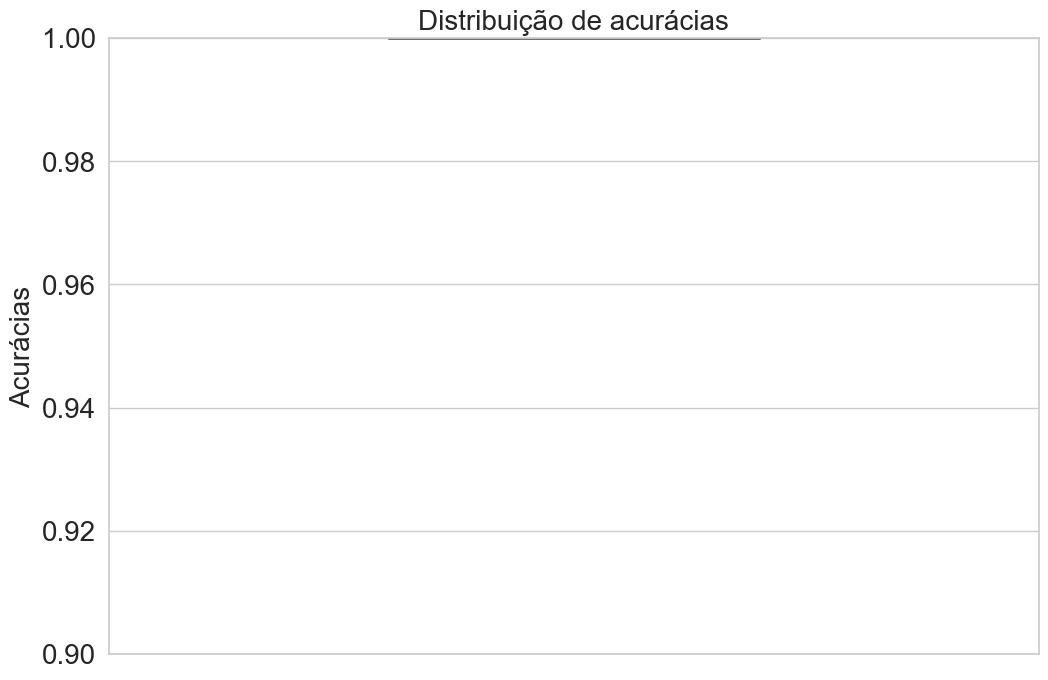

In [8]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=FIG_SIZE)
sns.boxplot(y=knn_accuracy_vector, width=0.4, color="skyblue", linewidth=2, fliersize=5)
plt.title("Distribuição de acurácias", fontsize=20)
plt.ylabel("Acurácias", fontsize=20)
plt.ylim(min(knn_accuracy_vector) - 0.1, 1)
plt.yticks(fontsize=20)
plt.show()

# Baseado na melhor acurácia, pego os indices de treino e teste que geraram ela e calculo a superfície de decisão e também resgato a sua respectiva matriz de confusão

In [9]:
max_accuracy = df_results_knn["accuracy"].max()
indexes_of_max_accuracy = df_results_knn[
    df_results_knn["accuracy"] == max_accuracy
].index.tolist()

index_selected = random.choice(indexes_of_max_accuracy)

print("Índices da melhor acurácia:", indexes_of_max_accuracy)
print("Índice selecionado:", index_selected)
print("Acurácia:", max_accuracy)

best_accuracy_train_indexes = df_results_knn.loc[index_selected, "train_indexes"]
best_accuracy_test_indexes = df_results_knn.loc[index_selected, "test_indexes"]

X_train, y_train, X_test, y_test = separate_train_test(
    df=synthetic_df,
    train_indexes=best_accuracy_train_indexes,
    test_indexes=best_accuracy_test_indexes,
    target_column_name=TARGET_COLUMN_NAME,
)

Índices da melhor acurácia: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Índice selecionado: 0
Acurácia: 1.0


# Resgatando a matriz de confusão e plotando ela

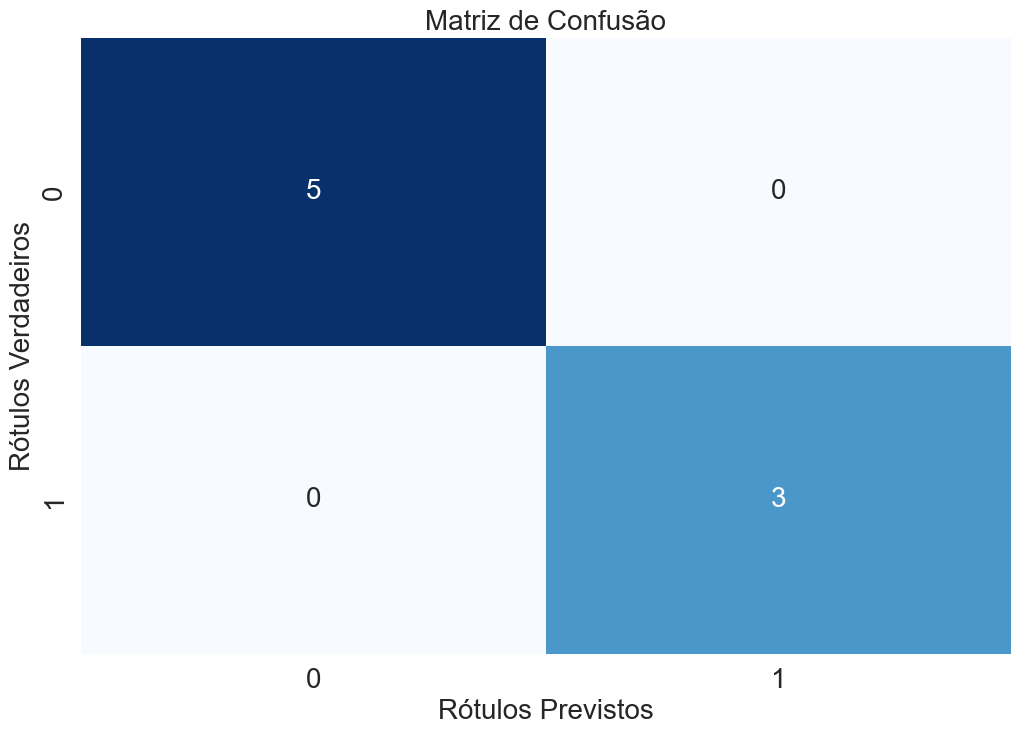

In [20]:
confusion_matrix_result = df_results_knn.loc[index_selected, "confusion_matrix"]

plt.figure(figsize=FIG_SIZE)
sns.heatmap(
    confusion_matrix_result,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 20},
)
plt.xlabel("Rótulos Previstos", fontsize=20)
plt.ylabel("Rótulos Verdadeiros", fontsize=20)
plt.title("Matriz de Confusão", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Calculo de superfície de decisão para o KNN

In [11]:
feature_x = X_train.columns[0]
feature_y = X_train.columns[1]

feature_x_max = X_train[feature_x].max()
feature_x_min = X_train[feature_x].min()

feature_y_max = X_train[feature_y].max()
feature_y_min = X_train[feature_y].min()

print(f"Feature {feature_x} - Máximo: {feature_x_max}, Mínimo: {feature_x_min}")
print(f"Feature {feature_y} - Máximo: {feature_y_max}, Mínimo: {feature_y_min}")

h = 0.01

xx, yy = np.meshgrid(
    np.arange(feature_x_min, feature_x_max + h, h),
    np.arange(feature_y_min, feature_y_max + h, h),
)

test_grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature_x, feature_y])

Z = knn_predict(
    X_train,
    y_train,
    test_grid,
    k=K_NUMBER,
    distance_calculator_function=calculate_euclidean_distance,
)

Z = Z.reshape(xx.shape)

Feature x1 - Máximo: 1.199465584480253, Mínimo: -0.28764930342251854
Feature x2 - Máximo: 1.2819459112971965, Mínimo: -0.2064032877982784


# Plot da superfície de decisão para o KNN

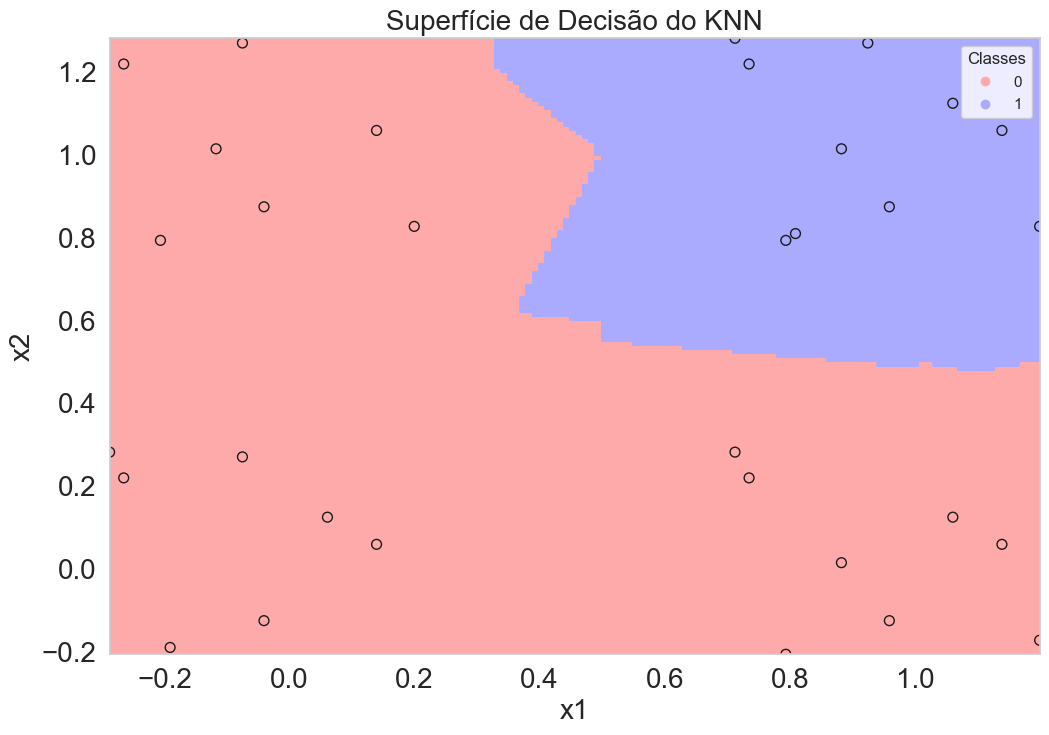

In [12]:
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])

plt.figure(figsize=FIG_SIZE)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
sc = plt.scatter(
    X_train[feature_x],
    X_train[feature_y],
    c=y_train,
    edgecolor="k",
    s=50,
    cmap=cmap_light,
)
plt.legend(*sc.legend_elements(), title="Classes", loc="upper right")

plt.xlabel(feature_x, fontsize=20)
plt.ylabel(feature_y, fontsize=20)
plt.title("Superfície de Decisão do KNN", fontsize=20)

plt.xlim(feature_x_min, feature_x_max)
plt.ylim(feature_y_min, feature_y_max)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Treinamento e avaliação dos modelos, juntamente com a criação de tabela de métricas para o NC(centróide mais próximo)

In [13]:
ncp_holdout_indexes = create_multiple_holdout_indexes(
    df=synthetic_df, n_indexes=HOLDOUT_INDEXES_NUMBER, test_size=TEST_SIZE
)

ncp_accuracy_list = []

for train_indexes, test_indexes in ncp_holdout_indexes:
    X_train, y_train, X_test, y_test = separate_train_test(
        df=synthetic_df,
        train_indexes=train_indexes,
        test_indexes=test_indexes,
        target_column_name=TARGET_COLUMN_NAME,
    )
    y_pred = nearest_centroid_predict(X_train=X_train, y_train=y_train, X_test=X_test)

    accuracy = calculate_accuracy(y_true=y_test, y_pred=y_pred)
    error_rate = calculate_error_rate(y_true=y_test, y_pred=y_pred)

    confusion_matrix_result = confusion_matrix(y_true=y_test, y_pred=y_pred)

    ncp_accuracy_list.append(
        (
            accuracy,
            error_rate,
            train_indexes,
            test_indexes,
            y_pred,
            confusion_matrix_result,
        )
    )

df_results_nc = pd.DataFrame(
    ncp_accuracy_list,
    columns=[
        "accuracy",
        "error_rate",
        "train_indexes",
        "test_indexes",
        "y_pred",
        "confusion_matrix",
    ],
)

df_results_nc

,accuracy,error_rate,train_indexes,test_indexes,y_pred,confusion_matrix
0,1.000,0.000,"[12, 36, 31, 16, 26, 29, 14, 6, 35, 34, 13, 38...","[3, 37, 7, 39, 10, 15, 22, 30]","[0, 1, 0, 1, 0, 0, 0, 1]","[[5, 0], [0, 3]]"
1,1.000,0.000,"[36, 15, 37, 16, 29, 3, 4, 33, 8, 17, 20, 5, 9...","[0, 34, 35, 7, 13, 14, 21, 25]","[0, 1, 1, 0, 0, 0, 0, 0]","[[6, 0], [0, 2]]"
2,1.000,0.000,"[13, 6, 10, 0, 26, 27, 18, 15, 22, 20, 32, 5, ...","[36, 38, 12, 16, 19, 21, 24, 25]","[1, 1, 0, 0, 0, 0, 0, 0]","[[6, 0], [0, 2]]"
3,1.000,0.000,"[31, 11, 17, 13, 12, 9, 25, 6, 38, 28, 26, 16,...","[34, 3, 5, 37, 10, 20, 21, 29]","[1, 0, 0, 1, 0, 0, 0, 0]","[[6, 0], [0, 2]]"
4,0.875,0.125,"[16, 6, 20, 14, 21, 23, 30, 24, 8, 37, 22, 26,...","[0, 32, 3, 36, 11, 18, 19, 25]","[0, 1, 0, 1, 1, 0, 0, 0]","[[5, 1], [0, 2]]"
5,1.000,0.000,"[14, 16, 23, 32, 15, 30, 34, 35, 5, 24, 17, 6,...","[0, 33, 4, 8, 10, 11, 13, 21]","[0, 1, 0, 0, 0, 0, 0, 0]","[[7, 0], [0, 1]]"
6,1.000,0.000,"[16, 30, 15, 35, 38, 8, 17, 27, 10, 11, 33, 20...","[1, 2, 5, 6, 7, 37, 13, 14]","[0, 0, 0, 0, 0, 1, 0, 0]","[[7, 0], [0, 1]]"
7,1.000,0.000,"[6, 34, 2, 38, 16, 1, 8, 15, 33, 32, 3, 24, 21...","[35, 4, 37, 39, 19, 25, 26, 30]","[1, 0, 1, 1, 0, 0, 0, 1]","[[4, 0], [0, 4]]"
8,1.000,0.000,"[12, 31, 30, 6, 26, 5, 35, 1, 11, 15, 2, 19, 1...","[0, 8, 10, 13, 20, 21, 22, 28]","[0, 0, 0, 0, 0, 0, 0, 0]",[[8]]
9,1.000,0.000,"[35, 1, 3, 13, 14, 4, 9, 39, 11, 38, 29, 2, 15...","[33, 36, 5, 6, 16, 23, 24, 26]","[1, 1, 0, 0, 0, 0, 0, 0]","[[6, 0], [0, 2]]"


# Vetor de acurácias

In [14]:
nc_accuracy_vector = pd.Series(df_results_nc["accuracy"])
nc_accuracy_vector

0     1.000
1     1.000
2     1.000
3     1.000
4     0.875
5     1.000
6     1.000
7     1.000
8     1.000
9     1.000
10    1.000
11    1.000
12    1.000
13    1.000
14    0.875
15    1.000
16    1.000
17    1.000
18    1.000
19    1.000
Name: accuracy, dtype: float64

# Boxplot das acurácias para o NC

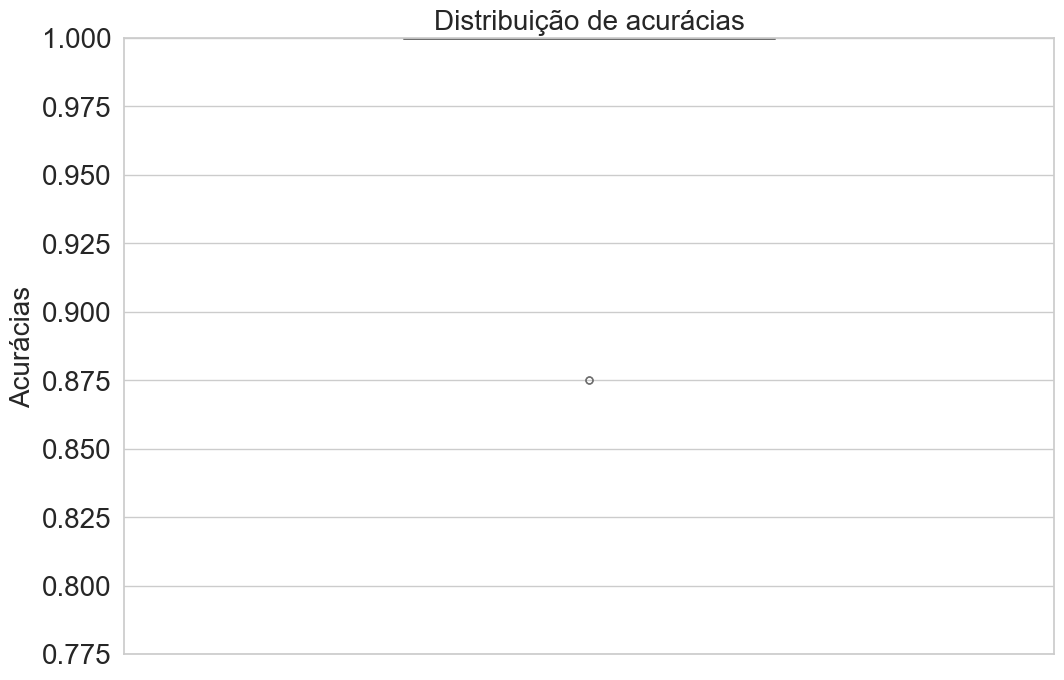

In [15]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=FIG_SIZE)
sns.boxplot(y=nc_accuracy_vector, width=0.4, color="skyblue", linewidth=2, fliersize=5)
plt.title("Distribuição de acurácias", fontsize=20)
plt.ylabel("Acurácias", fontsize=20)
plt.ylim(min(nc_accuracy_vector) - 0.1, 1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Baseado na melhor acurácia, pego os indices de treino e teste que geraram ela e calculo a superfície de decisão e também resgato a sua respectiva matriz de confusão

In [16]:
max_accuracy = df_results_nc["accuracy"].max()
indexes_of_max_accuracy = df_results_nc[
    df_results_nc["accuracy"] == max_accuracy
].index.tolist()

index_selected = random.choice(indexes_of_max_accuracy)

print("Índices da melhor acurácia:", indexes_of_max_accuracy)
print("Índice selecionado:", index_selected)
print("Acurácia:", max_accuracy)

best_accuracy_train_indexes = df_results_nc.loc[index_selected, "train_indexes"]
best_accuracy_test_indexes = df_results_nc.loc[index_selected, "test_indexes"]

X_train, y_train, X_test, y_test = separate_train_test(
    df=synthetic_df,
    train_indexes=best_accuracy_train_indexes,
    test_indexes=best_accuracy_test_indexes,
    target_column_name=TARGET_COLUMN_NAME,
)

Índices da melhor acurácia: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19]
Índice selecionado: 3
Acurácia: 1.0


# Resgatando a matriz de confusão e plotando ela

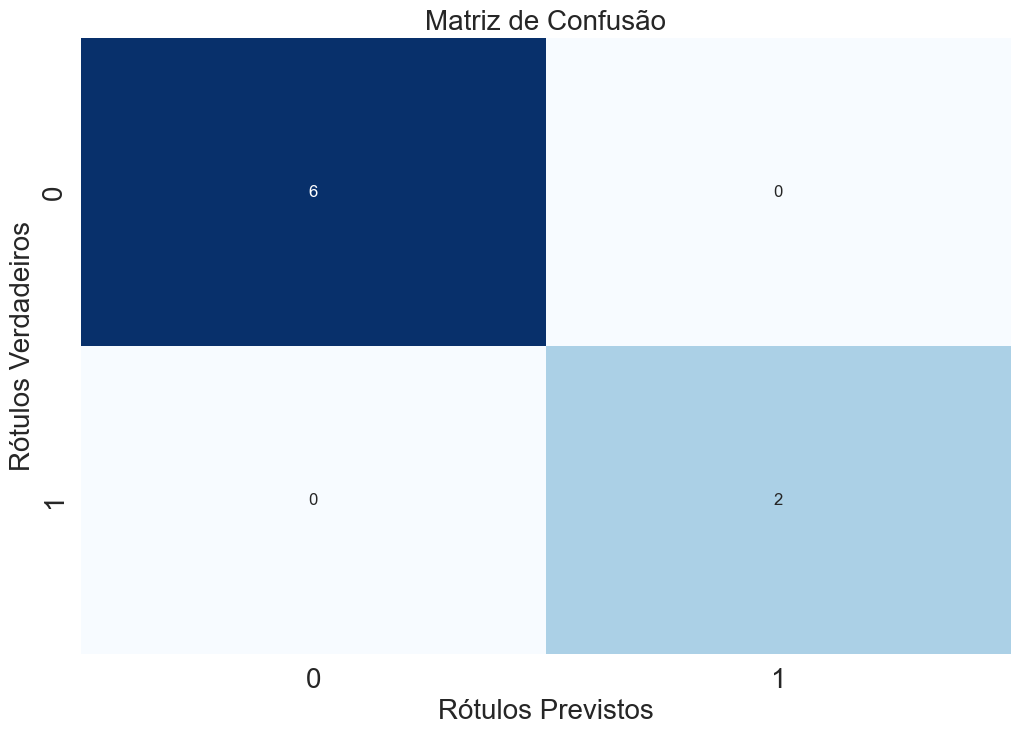

In [17]:
confusion_matrix_result = df_results_nc.loc[index_selected, "confusion_matrix"]


plt.figure(figsize=FIG_SIZE)
sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Rótulos Previstos", fontsize=20)
plt.ylabel("Rótulos Verdadeiros", fontsize=20)
plt.title("Matriz de Confusão", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Calculo de superfície de decisão para NR

In [18]:
feature_x = X_train.columns[0]
feature_y = X_train.columns[1]

feature_x_max = X_train[feature_x].max()
feature_x_min = X_train[feature_x].min()

feature_y_max = X_train[feature_y].max()
feature_y_min = X_train[feature_y].min()

print(f"Feature {feature_x} - Máximo: {feature_x_max}, Mínimo: {feature_x_min}")

print(f"Feature {feature_y} - Máximo: {feature_y_max}, Mínimo: {feature_y_min}")

h = 0.01

xx, yy = np.meshgrid(
    np.arange(feature_x_min, feature_x_max + h, h),
    np.arange(feature_y_min, feature_y_max + h, h),
)

test_grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature_x, feature_y])

Z = nearest_centroid_predict(X_train, y_train, test_grid)

Z = Z.reshape(xx.shape)

Feature x1 - Máximo: 1.199465584480253, Mínimo: -0.28764930342251854
Feature x2 - Máximo: 1.2819459112971965, Mínimo: -0.2064032877982784


# Plot da superfície de decisão para o NC

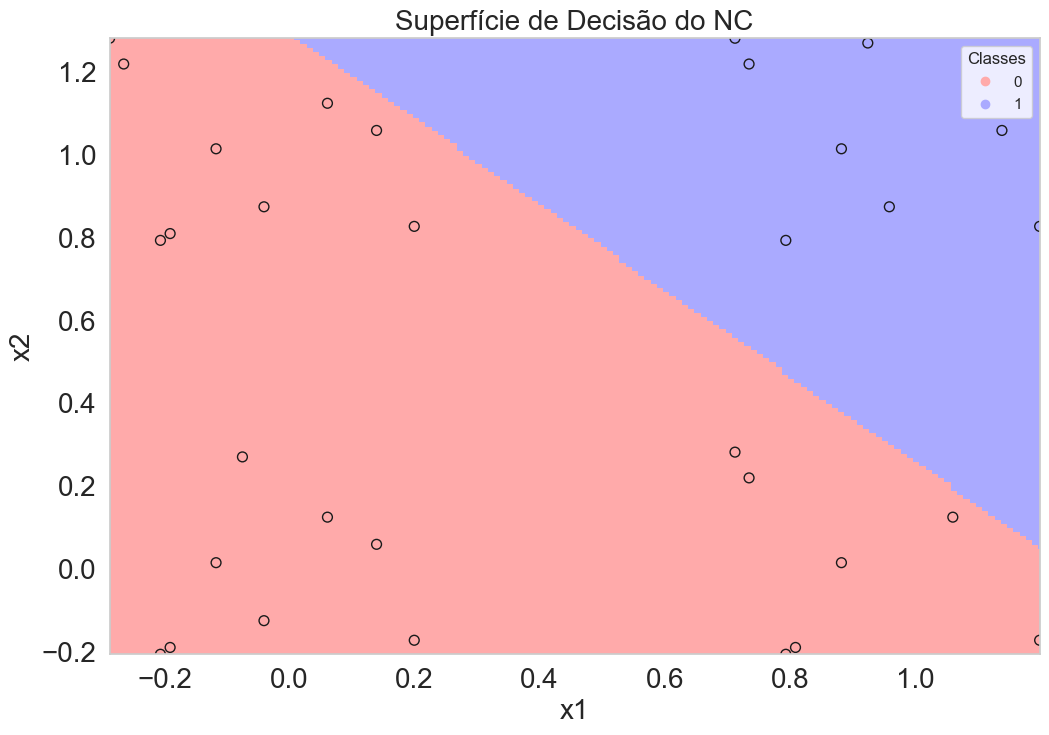

In [19]:
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])

plt.figure(figsize=FIG_SIZE)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
sc = plt.scatter(
    X_train[feature_x],
    X_train[feature_y],
    c=y_train,
    edgecolor="k",
    s=50,
    cmap=cmap_light,
)
plt.legend(*sc.legend_elements(), title="Classes", loc="upper right")

plt.xlabel(feature_x, fontsize=20)
plt.ylabel(feature_y, fontsize=20)
plt.title("Superfície de Decisão do NC", fontsize=20)

plt.xlim(feature_x_min, feature_x_max)
plt.ylim(feature_y_min, feature_y_max)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()